In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu' )

In [21]:
device, torch.__version__

(device(type='cpu'), '1.13.0+cpu')

In [3]:
# train = True --> default 
train_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    ,train = True
)

test_dataset =  torchvision.datasets.FashionMNIST(
    './fashionMnist/data', download=True,transform=transforms.Compose([ transforms.ToTensor() ])
    , train = False
)

In [4]:
# 데이터 셋으로부터 데이터 로드하기
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

In [5]:
for i in train_loader:
    a, b = i
    print(a.shape,len(b))
    break

torch.Size([100, 1, 28, 28]) 100


In [6]:
# 600번 순환
len(train_loader)

600

In [7]:
# train data total = 100*600 = 60000

In [8]:
len(test_loader)

100

In [9]:
# test data total = 100*100 = 10000

In [10]:
temp1 = ['T-shirt/top'
,'Trouser'
,'Pullover'
,'Dress'
,'Coat'
,'Sandal'
,'Shirt'
,'Sneaker'
,'Bag'
,'Ankle boot'
]
temp2 = list(range(len(temp1)))
labelMap = dict(zip(temp2,temp1))

In [11]:
labelMap

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [12]:
len(train_dataset), np.random.randint(len(train_dataset))

(60000, 30063)

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

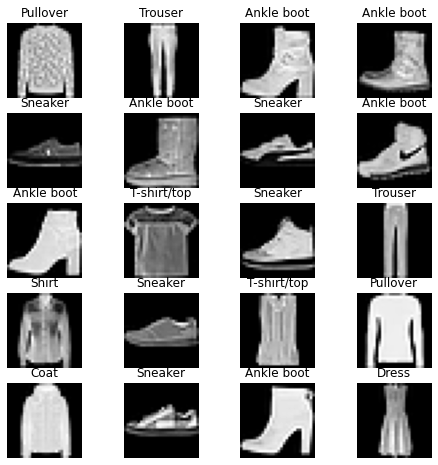

In [14]:
# 이미지 시각화
# ([0, 1, 28, 28],0)
fig = plt.figure(figsize=(8,8))
columns = 4;
rows = 5
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]    # torch.Size([28, 28])
    fig.add_subplot(rows,columns,i)
    plt.title(labelMap[ train_dataset[img_xy][1] ])
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()    

In [15]:
# ConvNet 미적용 신경망 설계
# F.relu() : forward에서 정의
# nn.Relu() : __init___에서 정의
class FashionDNN(nn.Module):
    def __init__(self):  # nn.OOO 는 init에서 설정  ㄹ
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features=256)  # 입력층
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)  # hidden layer 1
        self.fc3 = nn.Linear(in_features=128,out_features=10)  # 출력층
        
    # override 된 함수로 반드시 forward 라고 해야 하며
    # FashionDNN 객체를  데이터와 함께 호출하면 forward 가 자동으로 실행  callback함수임
    def forward(self, input_data):  # 전방계산을 위한 연결  순전파학습
        # 최초 입력을 설계한 입력 shape에 맞게 resize
        out = input_data.view(-1,784)  # reshape와 동일
        out = self.fc1(out)
        out = self.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out        
        
        

In [16]:
# 모델 객체
lr = 1e-3  # 0.001
model = FashionDNN()
model.to(device)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

In [17]:
# 손실함수 옵티마이져 
criterion = nn.CrossEntropyLoss()  #분류문제에서 사용
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
# 학습하기 위한 하이퍼 파라메터
num_epochs = 5
count = 0
loss_list, iteration_list,accuracy_list, prediction_list, labels_list = [],[],[],[],[]

In [24]:
# 학습
for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 모델이 데이터를 처리하기 위해 동일한 장치에 있어야 함
        # 자동미분
        # Autograd : 자동미분의 값을 저장하기위해서 tape를 사용
        # 순전파, 역전파
        train = Variable(images.view(100,1,28,28)) # 사이즈 조정(이미 되어 있어서 안해도 되지만... 일관성을 위해서)
        
        labels = Variable(labels)
        outputs = model(train)  # 학습데이터 모델에 적용
        loss = criterion(outputs,labels)
        optimizer.zero_grad() # 기울기는 가중치와 달라서 업데이트 되면 안됨 그래서 매번 초기화 함
        loss.backward() # 오차를 각 가중치에 업데이트하는데. 기여한 만큼 한다.( 오차에 가중치미분값을 곱해서 나온값을 각 가중치에 빼준다)
        optimizer.step() # 옵티마이져를 업데이트(zero)
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                prediction_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            accuracy = correct*100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if not (count % 500):
            print(f"Iteration : {count}, Loss : {loss.data}, Accuracy : {accuracy}")
        

Iteration : 500, Loss : 0.5197024941444397, Accuracy : 84.08999633789062
Iteration : 1000, Loss : 0.4137642979621887, Accuracy : 84.58999633789062
Iteration : 1500, Loss : 0.3613997995853424, Accuracy : 84.51000213623047
Iteration : 2000, Loss : 0.43334415555000305, Accuracy : 85.61000061035156
Iteration : 2500, Loss : 0.2584071457386017, Accuracy : 85.9800033569336
Iteration : 3000, Loss : 0.2810910940170288, Accuracy : 85.76000213623047


In [25]:
# 정확도를 가지고 측정할때는 모든 클래스가 동등하게 고려된 것인지, 특정 클래스의 분류가 높았던 것인지 모른다...
# 데이터의 특성에 따른 정확도를 잘 관측해야 함.

# 합성곱 신경망

In [29]:
class FashionCNN(nn.Module):
    def __init__(self):
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3) # [32,784,784]
            ,nn.BatchNorm2d(32)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2,stride=2) # [32,392,392]
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)  # [64,32,32]
            ,nn.BatchNorm2d(64)  # 학습과정에서 각 배치단위별로 데이터가 다양한 분포를 가지더라도 평균과 분산을 이용해서 정규화
            ,nn.LeakyReLU()
            ,nn.MaxPool2d(2)  # [64,16,16]  
        )
        # Conv2d 에서 출력 크기 구하는 공식
        # 이미지 형태의 데이터를 배열 형태로 변환작업  (W-F+2P)/S+1
        # W : 입력데이터의 크기
        # F:커널 크기
        # P:패딩크기
        # S:스트라이드
        # (784-3+(2*1))/2+1 = 784  -> [32,784,784]
        
        # MaxPool2d에서 출력 크기 구하는 공식
        # IF/F
        # IF : 입력필터의 크기 또는 바로 앞의 Conv2d의 출력크기
        # F : 커널 크기
        # 784 / 2 = 392
        #[32,392,392]       
        
        
        
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out        